# <font size = 5> Notes</font>

Part 5 of 5: Analysis

Author: Huan Q. Bui

Affiliation: Fermi1 experiment at Zlabs, MIT
             
PI: Professor Martin Zwierlein

First updated: May 15, 2023

Last updated: August 13, 2023

# <font size = 5>Setting up</font>

In [654]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
from qutip import *
import scipy.constants
import pickle
from tkinter import filedialog # for prompting user to set analysis folder
import glob
# imports for analysis code:
import h5py
from pathlib import Path

image_utils_directory = '/Users/huanbui/Documents/GitHub/labscript-suite/userlib/analysislib/common/image_utils'
sys.path.append(image_utils_directory)
from rawImage import AbsorptionImage, FluorescenceImage

In [2]:
# suppress warnings: do at your own risk!
import warnings
warnings.filterwarnings("ignore")

In [3]:
# constants
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# physics constants
hbar = 1.05457182*10**(-34) # Js
c = 299792458 # m/s
h_planck = hbar*2*np.pi  # Js
me = 9.1093837015e-31    # electron mass
mn = 1.67493e-27         # neutron mass
eC = 1.60218e-19         # electric charge
muB = eC*hbar/(2*me)     # Bohr magneton
muB_cm1_G = muB / (100*c*h_planck*1e4) # Bohr magneton in units of cm-1 per Gauss
a0 = 5.2917720859e-11    # Bohr radius
muN = scipy.constants.physical_constants['nuclear magneton'][0]
eps0 = scipy.constants.epsilon_0
gS = 2.0023193043622
DebyeSI = 3.33564e-30

# Lithium constants
mLi6 = 9.9883414*10**(-27) # kg
Li6D2Gamma = 5.8724e6 # Hz Note that this is NOT angular freq
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)
Li6Ahf_s12 = 152.1368407e6  # This is NOT angular freq
Li6Bhf_s12 = 0
Li6Ahf_p12 = 17.386e6 # Hz
Li6Bhf_p12 = 0
Li6Ahf_p32 = -1.155e6 # Hz
Li6Bhf_p32 = -0.10e6 # Hz
Li6I = 1
Li6gI = -0.0004476540

# Sodium-23 constants
mNa23 = 0.38175403519e-25 # kg
Na23D2Gamma = 9.794646e6 # Hz
Na23D2lambda0 = 589.158326415e-9 # meters
Na23D2sigma0 = 3*(Na23D2lambda0)**2/(2*np.pi)
Na23Ahf_s12 = 885.8130644050e6 # Hz
Na23Bhf_s12 = 0e6 # Hz
Na23Ahf_p12 = 94.4413e6 # Hz
Na23Bhf_p12 = 0e6 # Hz
Na23Ahf_p32 = 18.53415e6 # Hz
Na23Bhf_p32 = 2.72430e6 # Hz
Na23I = 3/2
Na23gI = -0.0008046108080

# Potassium-40 constants
mK40 = 39.9639984821*1.6605402e-27 # kg 
K40D2Gamma = 6.03511 # MHz
K40D2lambda0 = 766.700674872173e-9 # meters
K40D2sigma0 = 3*(K40D2lambda0)**2/(2*np.pi)
K40Ahf_s12 = -285.730824e6 # Hz
K40Bhf_s12 = 0
K40Ahf_p12 = -34.52325e6 # Hz
K40Bhf_p12 = 0
K40Ahf_p32 = -7.58510e6 # Hz
K40Bhf_p32 = -3.44590e6 # Hz
K40I = 4
K40gI = 0.00017649034

# NaK constants:
mK41 = 6.80187059497004e-26 # kg
mK40 = 6.63617749148248e-26 # kg
mK39 = 6.47007514485677e-26 # kg
u = 1.660538782e-27  # kg
Eh = 4.35974394e-18 
RKRcst = hbar/np.sqrt(2*u) * (10**10) * np.sqrt(1/(100 * c * hbar * 2*np.pi)) 
muNa39K = (mNa23 * mK39)/(mNa23 + mK39) * 1/u # atomic units
muNa40K = (mNa23 * mK40)/(mNa23 + mK40) * 1/u # atomic units 
muNa41K = (mNa23 * mK41)/(mNa23 + mK41) * 1/u # atomic units

# <font size = 5>PA analysis</font>

In [4]:
# helper functions
def round_frequency(frequency_THz, precision):
    """
    Take a THz frequency and round it to a given precision in Hz. Written for use with wavemeter.
    Example:
    >> test_freq_THz = 123.456789
    >> precision = 3e8
    >> print(round_frequency(test_freq_THz, precision))
    >> 123.4569
    """
    frequency = frequency_THz * 1e12
    rounded_frequency = round(frequency / precision) * precision
    return rounded_frequency / 1e12

def raw_to_averages_and_stdev(x_var, y_var):
    result_x_var = np.unique(x_var)
    y_var_averages = np.empty(result_x_var.shape)
    y_var_stdevs   = np.empty(result_x_var.shape)

    for i, x in enumerate(result_x_var):
        y_var_averages[i] = np.mean(y_var[x_var == x])
        y_var_stdevs[i]   = np.std(y_var[x_var == x])
    return result_x_var, y_var_averages, y_var_stdevs

def sum_of_lorentzians(xdata, *params):
    n = (len(params) - 1) // 3
    offset = params[-1]
    ydata = xdata*0
    for i in range(n):
        center = params[i]
        width = params[i + n]
        amplitude = params[i + 2*n]
        ydata += amplitude * width / ( (xdata-center)**2 + (width/2)**2)
    return ydata + offset

In [5]:
# get data folder path
folder_path = filedialog.askdirectory()
filepaths = sorted(glob.glob(folder_path + '/*.pkl'))
df = pickle.load(open(filepaths[0], 'rb'))
for filepath in filepaths:
    df = df.append(pickle.load(open(filepath, 'rb')))

2023-10-08 20:05:05.760 python[13580:36837621] +[CATransaction synchronize] called within transaction
/var/folders/v2/qlb19m_922j0wts1jqdyjw100000gn/T/ipykernel_13580/280826968.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pickle.load(open(filepath, 'rb')))
/var/folders/v2/qlb19m_922j0wts1jqdyjw100000gn/T/ipykernel_13580/280826968.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pickle.load(open(filepath, 'rb')))
/var/folders/v2/qlb19m_922j0wts1jqdyjw100000gn/T/ipykernel_13580/280826968.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pickle.load(open(filepath, 'rb')))
/var/folders/v2/qlb19m_922j0wts1jqdyjw100000gn/T/ipykernel_13580/280826968.py:6: FutureWarning: The 

In [64]:
# get PA data 
upleg_frequencies_THz     = df['zcam_triple_analysis']['UPLEG_FREQUENCY'] - 372 # THz
upleg_frequencies_GHz     = round_frequency(upleg_frequencies_THz, precision = 4e6) * 1e3 # GHz
K_m92_NcntLarge_raw       = df['zcam_triple_analysis']['K2_NcntLarge']
K_m92_transferLarge_raw   = df['zcam_triple_analysis']['K2_transferLarge']
K_m72_NcntLarge_raw       = df['zcam_triple_analysis']['K1_NcntLarge']
K_m72_transferLarge_raw   = df['zcam_triple_analysis']['K1_transferLarge']
Na_NcntLarge_raw          = df['zcam_triple_analysis']['Na_NcntLarge']

upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, K_m92_NcntLarge_std         = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m92_NcntLarge_raw)
upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, K_m92_transferLarge_std = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m92_transferLarge_raw)
upleg_frequencies_GHz_unique, K_m72_NcntLarge_avg, K_m72_NcntLarge_std         = raw_to_averages_and_stdev(upleg_frequencies_GHz, K_m72_NcntLarge_raw)
upleg_frequencies_GHz_unique, Na_NcntLarge_avg, Na_NcntLarge_std               = raw_to_averages_and_stdev(upleg_frequencies_GHz, Na_NcntLarge_raw)

In [65]:
# guess and fit PA lines
center_guesses             = np.array([553.72, 553.84, 553.95, 554.14, 554.19, 554.23, 554.28])
width_guesses              = np.array([40,     40,     40,     40,     40,     40,     40]) * 1e-3  
amplitude_guesses_transfer = np.array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])
offset_guesses_transfer    = np.array([0.4])
amplitude_guesses_counts   = np.array([-200, -200, -200, -200, -200, -200, -200])
offset_guesses_counts      = np.array([400])
# puting guesses together
initial_guess_transfer = np.concatenate((center_guesses, width_guesses, amplitude_guesses_transfer, offset_guesses_transfer))
initial_guess_counts = np.concatenate((center_guesses, width_guesses, amplitude_guesses_counts, offset_guesses_counts))
params_PA_transfer, covariance_PA_transfer = scipy.optimize.curve_fit(sum_of_lorentzians, upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, 
                                                              p0    = initial_guess_transfer)
params_PA_counts, covariance_PA_counts     = scipy.optimize.curve_fit(sum_of_lorentzians, upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, 
                                                              p0    = initial_guess_counts)
freqs = np.linspace(min(upleg_frequencies_GHz_unique), max(upleg_frequencies_GHz_unique), 1000)
PA_transfer_lines = sum_of_lorentzians(freqs, *params_PA_transfer)
PA_counts_lines   = sum_of_lorentzians(freqs, *params_PA_counts)

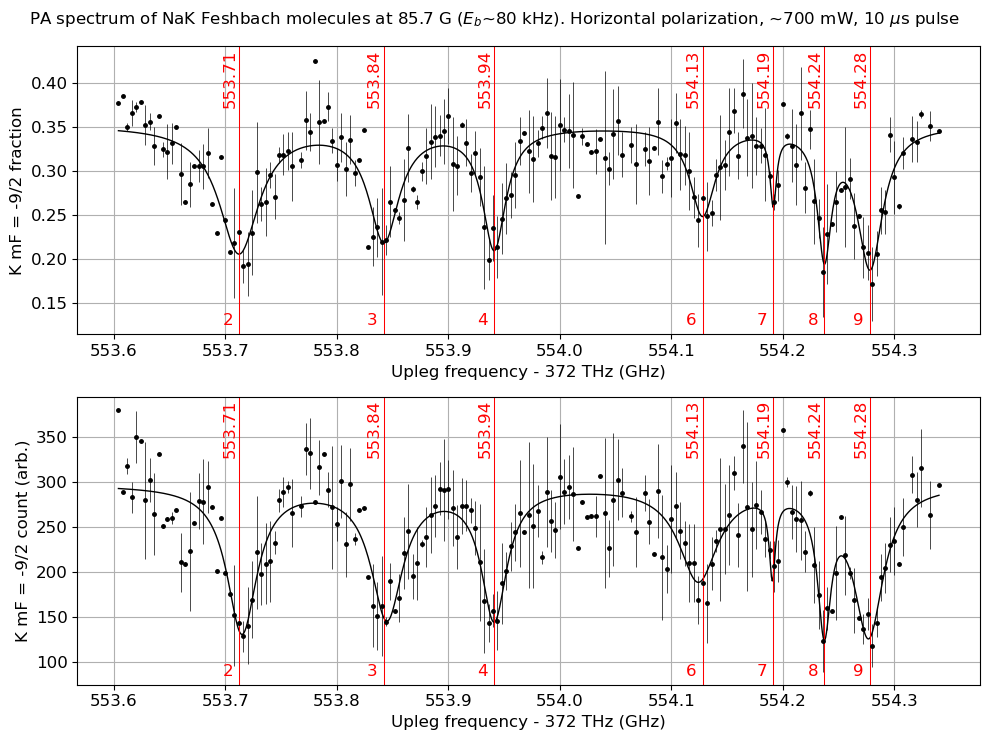

In [66]:
# plot K m92 counts and transfers
fig_Km92, ax_Km92 = plt.subplots(2,1,figsize = (10,7.5))

line_labels = [2,3,4,6,7,8,9]
transferLarge_PA_lines_from_fit = params_PA_transfer[0:7]
ax_Km92[0].errorbar(upleg_frequencies_GHz_unique, K_m92_transferLarge_avg, yerr = K_m92_transferLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
ax_Km92[0].plot(freqs, PA_transfer_lines, color = 'black', linewidth = 1.0)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km92[0].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km92[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 0.375, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km92[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 0.125, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')    
ax_Km92[0].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km92[0].set_ylabel('K mF = -9/2 fraction', fontsize = 12)
ax_Km92[0].tick_params(axis='both', which='major', labelsize=12)
ax_Km92[0].tick_params(axis='both', which='minor', labelsize=12)
ax_Km92[0].grid()

# counts_PA_lines_from_fit = params_PA_counts[0:7]
ax_Km92[1].errorbar(upleg_frequencies_GHz_unique, K_m92_NcntLarge_avg, yerr = K_m92_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth = 0.5)
ax_Km92[1].plot(freqs, PA_counts_lines, color = 'black', linewidth = 1.0)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km92[1].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km92[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 330, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km92[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 85, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km92[1].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km92[1].set_ylabel('K mF = -9/2 count (arb.)', fontsize = 12)
ax_Km92[1].tick_params(axis='both', which='major', labelsize=12)
ax_Km92[1].tick_params(axis='both', which='minor', labelsize=12)
ax_Km92[1].grid()

fig_Km92.suptitle('PA spectrum of NaK Feshbach molecules at 85.7 G ($E_b$~80 kHz). Horizontal polarization, ~700 mW, 10 $\mu$s pulse')
fig_Km92.tight_layout()
fig_Km92.show()

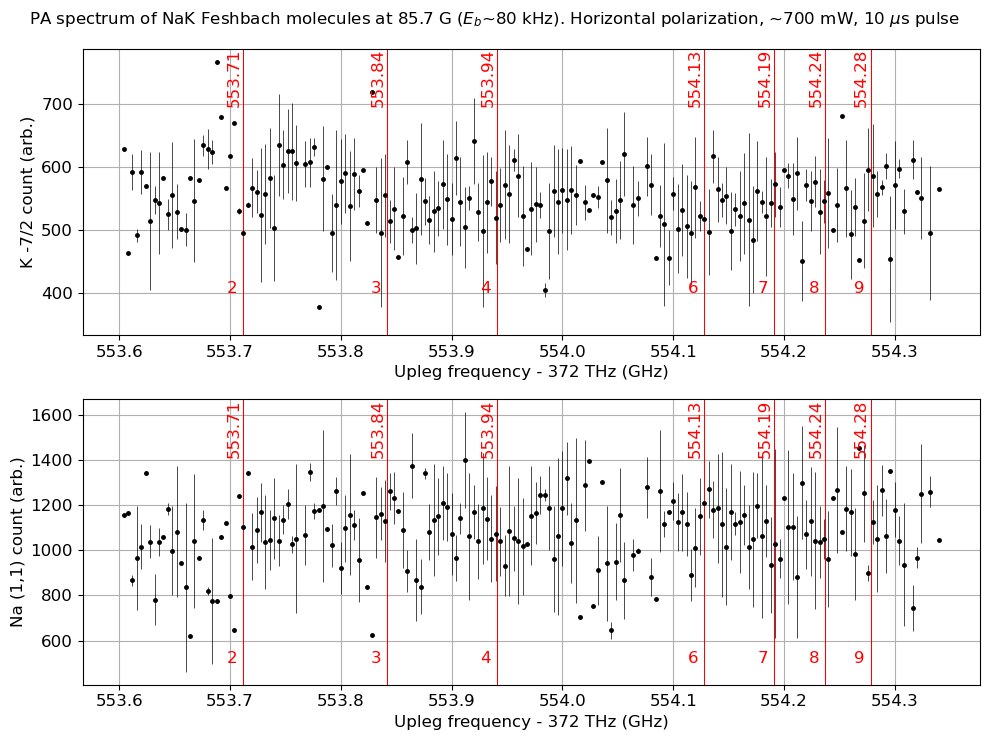

In [67]:
# plot K m72 and Na counts and transfers
fig_Km72_Na, ax_Km72_Na = plt.subplots(2,1,figsize = (10,7.5))
ax_Km72_Na[0].errorbar(upleg_frequencies_GHz_unique, K_m72_NcntLarge_avg, yerr = K_m72_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km72_Na[0].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km72_Na[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 700, 
                    rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km72_Na[0].text(transferLarge_PA_lines_from_fit[i]-0.015, 400, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km72_Na[0].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km72_Na[0].set_ylabel('K -7/2 count (arb.)', fontsize = 12)
ax_Km72_Na[0].tick_params(axis='both', which='major', labelsize=12)
ax_Km72_Na[0].tick_params(axis='both', which='minor', labelsize=12)
ax_Km72_Na[0].grid()

ax_Km72_Na[1].errorbar(upleg_frequencies_GHz_unique, Na_NcntLarge_avg, yerr = Na_NcntLarge_std, fmt = '.', color = 'black', markersize = 5, elinewidth=0.5)
for i in range(len(transferLarge_PA_lines_from_fit)):
    ax_Km72_Na[1].axvline(transferLarge_PA_lines_from_fit[i], color = 'red', linewidth = 0.75)
    ax_Km72_Na[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 1420, 
                rotation = 'vertical', s= "{:.2f}".format(transferLarge_PA_lines_from_fit[i]), fontsize = 12, color = 'red')
    ax_Km72_Na[1].text(transferLarge_PA_lines_from_fit[i]-0.015, 500, 
                    rotation = 'horizontal', s= "{:.0f}".format(line_labels[i]), fontsize = 12, color = 'red')
ax_Km72_Na[1].set_xlabel('Upleg frequency - 372 THz (GHz)', fontsize = 12)
ax_Km72_Na[1].set_ylabel('Na (1,1) count (arb.)', fontsize = 12)
ax_Km72_Na[1].tick_params(axis='both', which='major', labelsize=12)
ax_Km72_Na[1].tick_params(axis='both', which='minor', labelsize=12)
ax_Km72_Na[1].grid()

fig_Km72_Na.suptitle('PA spectrum of NaK Feshbach molecules at 85.7 G ($E_b$~80 kHz). Horizontal polarization, ~700 mW, 10 $\mu$s pulse')
fig_Km72_Na.tight_layout()
fig_Km72_Na.show()

# <font size = 5>Python ZCAM triple imaging analysis</font>

The purpose of this code to to replace the Fermi1's MATLAB analysis code for ZCam triple imaging. At the highest level, this is function which takes in image filpaths and analysis settings and returns analysis results. We will work out the details later. 

In [708]:
# helper functions
def get_image_paths(h5_path):
    """
    Returns a list of mac image filepath strings stored in h5 file
    """
    with h5py.File(h5_path, 'r') as h5_file:
        image_paths = [x.decode() for x in h5_file['image_filepaths'][:,0]]
        HQB_Mac_paths = []
        for path in image_paths:
            mac_path = path.replace('\\', '/')
            HQB_Mac_paths.append( mac_path.replace('Z:', '/Volumes/Fermi1') )
        return HQB_Mac_paths

def get_frames_from_absorption_image_path(image_path):
    return AbsorptionImage(image_path, plot_raw_images=False, plot_OD=False)

def get_analysis_settings(analysis_settings_filepath):
    with open(analysis_settings_filepath, 'rb') as f:
        data = pickle.load(f)
    return data

def display_raw_OD_image_with_ROI_and_normbox(ax, frames, ROI, small_ROI, normbox, min_OD = 0, max_OD = 1.3):
    xmin, xmax, ymin, ymax = ROI[0], ROI[1], ROI[2], ROI[3]
    xmin_small, xmax_small, ymin_small, ymax_small = small_ROI[0], small_ROI[1], small_ROI[2], small_ROI[3]
    xmin_NB, xmax_NB, ymin_NB, ymax_NB = normbox[0], normbox[1], normbox[2], normbox[3]
    ax.imshow(frames.OD.T, origin='lower', cmap = 'gray_r').set_clim(min_OD, max_OD)
    ROI_rect = patches.Rectangle((xmin, ymin), abs(xmin - xmax), abs(ymin - ymax), linewidth=1, edgecolor='r', facecolor = 'none')
    small_ROI_rect = patches.Rectangle((xmin_small, ymin_small), abs(xmin_small - xmax_small), 
                                       abs(ymin_small - ymax_small), linewidth=0.5, edgecolor='r', facecolor = 'none')
    NB_rect  = patches.Rectangle((xmin_NB, ymin_NB), abs(xmin_NB - xmax_NB), abs(ymin_NB - ymax_NB), linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(ROI_rect)
    ax.add_patch(small_ROI_rect)
    ax.add_patch(NB_rect)
    return ax

def background_normalized_OD(frames, ROI, normbox):
    # boxes of the form [xmin, xmax, ymin, xmax]
    xmin, xmax, ymin, ymax = ROI[0], ROI[1], ROI[2], ROI[3]
    xmin_NB, xmax_NB, ymin_NB, ymax_NB = normbox[0], normbox[1], normbox[2], normbox[3]

    wa_NB  = frames.img_w_atoms[xmin_NB:xmax_NB, ymin_NB:ymax_NB].astype(float)
    woa_NB = frames.img_no_atoms[xmin_NB:xmax_NB, ymin_NB:ymax_NB].astype(float)
    wa_ROI = frames.img_w_atoms[xmin:xmax, ymin:ymax].astype(float)
    woa_ROI = frames.img_no_atoms[xmin:xmax, ymin:ymax].astype(float)
    dark_ROI = frames.img_bkgd[xmin:xmax, ymin:ymax].astype(float)

    norm_factor = sum(sum(wa_NB))/sum(sum(woa_NB))
    adjusted_woa_ROI = woa_ROI * norm_factor
    background_normalized_fakeOD = (wa_ROI - dark_ROI) / (adjusted_woa_ROI - dark_ROI)
    background_normalized_OD = -np.log(background_normalized_fakeOD)
    # clean
    background_normalized_OD = np.nan_to_num(background_normalized_OD, nan = 0.0, posinf=3.0, neginf=0.0)
    background_normalized_OD = np.clip(background_normalized_OD, -3, 3)
    background_normalized_OD = background_normalized_OD.astype(float)

    # light level:
    area = abs((ROI[0] - ROI[1])*(ROI[2] - ROI[3]))
    light_level = sum(sum(woa_ROI - dark_ROI)) / area
    
    return norm_factor, light_level, background_normalized_OD

In [709]:
def gaussian_function(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def fit_gaussian_to_data(x, y):
    initial_guess = [2*(np.max(y) - np.min(y)), np.argmax(y) + np.min(x), (np.max(x) - np.min(x))/3, np.min(y)]
    bounds = ((0, np.min(x), 0, 0),(np.inf,np.max(x), np.max(x), np.max(y)))
    optimized_params, _ = curve_fit(gaussian_function, x, y, p0=initial_guess, bounds=bounds)
    return tuple(optimized_params)

def autocenter_from_search_ROI(frames, search_ROI, search_mode = 'gaussian'):
    xcenter = round( (search_ROI[0] + search_ROI[1])/2)
    ycenter = round( (search_ROI[2] + search_ROI[3])/2)
    OD_ROI = frames.OD[search_ROI[0]:search_ROI[1], search_ROI[2]: search_ROI[3]]
    
    # find ycenter relative to ymin by summing over x:
    OD_summed_over_x = np.sum(OD_ROI, axis = 0)
    ycenter = np.argmax(OD_summed_over_x) + search_ROI[2]
    y_pix = np.arange(search_ROI[2], search_ROI[3],1)
    # plt.plot(y_pix, OD_summed_over_x)
    if search_mode == 'gaussian':
        # fit gaussian to data and return optimized params:
        fit_res = fit_gaussian_to_data(x = y_pix, y = OD_summed_over_x)
        ycenter = round(fit_res[1])
        # plt.plot(y_pix, gaussian_function(y_pix, fit_res[0], fit_res[1], fit_res[2], fit_res[3]))
    # plt.show()

    # find xcenter relative to xmin by summing over y:
    OD_summed_over_y = np.sum(OD_ROI, axis = 1)
    xcenter = np.argmax(OD_summed_over_y) + search_ROI[0]
    x_pix = np.arange(search_ROI[0], search_ROI[1],1)
    # plt.plot(x_pix, OD_summed_over_y)
    if search_mode == 'gaussian':
        # fit gaussian to data and return optimized params:
        fit_res = fit_gaussian_to_data(x = x_pix, y = OD_summed_over_y)
        xcenter = round(fit_res[1])
        # plt.plot(x_pix, gaussian_function(x_pix, fit_res[0], fit_res[1], fit_res[2], fit_res[3]))
    # plt.show()

    return xcenter, ycenter

In [718]:
def zcam_triple_image_analysis(filepath_Na, filepath_K2, filepath_K1, autocenter = True, center_search_mode = None):
    Na_frames = get_frames_from_absorption_image_path(filepath_Na)
    K2_frames = get_frames_from_absorption_image_path(filepath_K2)
    K1_frames = get_frames_from_absorption_image_path(filepath_K1)

    auto_center = True
    search_ROI_Na = [0, 300, 0, 200]
    search_ROI_K  = [550, 800, 0, 150]
    
    if auto_center:
        xcenter_Na, ycenter_Na = autocenter_from_search_ROI(frames = Na_frames, search_ROI = search_ROI_Na, search_mode=center_search_mode)
        xcenter_K, ycenter_K   = autocenter_from_search_ROI(frames = K2_frames,  search_ROI = search_ROI_K, search_mode=center_search_mode)
    else:
        xcenter_Na, ycenter_Na = 140, 80
        xcenter_K, ycenter_K = 675, 65
        
    # large counting box:
    x_size_Na, y_size_Na = 180, 40
    x_size_K, y_size_K = 150, 40
    # small counting box:
    x_size_Na_small, y_size_Na_small = 30, 20
    x_size_K_small, y_size_K_small = 30, 15

    # Na ROI:
    xmin_Na, xmax_Na, ymin_Na, ymax_Na =  round(xcenter_Na-x_size_Na/2), round(xcenter_Na+x_size_Na/2), round(ycenter_Na-y_size_Na/2), round(ycenter_Na+y_size_Na/2)
    ROI_Na = [xmin_Na, xmax_Na, ymin_Na, ymax_Na]
    small_ROI_Na = [round(xcenter_Na-x_size_Na_small/2), round(xcenter_Na+x_size_Na_small/2), 
                    round(ycenter_Na-y_size_Na_small/2), round(ycenter_Na+y_size_Na_small/2)]
    # Na Normbox:
    xmin_Na_NB, xmax_Na_NB, ymin_Na_NB, ymax_Na_NB = xmin_Na, xmax_Na, ymax_Na+10, ymax_Na+y_size_Na+10 
    normbox_Na = [xmin_Na_NB, xmax_Na_NB, ymin_Na_NB, ymax_Na_NB]
    # K ROI:
    xmin_K, xmax_K, ymin_K, ymax_K = round(xcenter_K-x_size_K/2), round(xcenter_K+x_size_K/2), round(ycenter_K-y_size_K/2), round(ycenter_K+y_size_K/2)
    ROI_K = [xmin_K, xmax_K, ymin_K, ymax_K]
    small_ROI_K = [round(xcenter_K-x_size_K_small/2), round(xcenter_K+x_size_K_small/2), 
                   round(ycenter_K-y_size_K_small/2), round(ycenter_K+y_size_K_small/2)]
    # K Normbox:
    xmin_K_NB, xmax_K_NB, ymin_K_NB, ymax_K_NB = xmin_K, xmax_K, ymax_K+10, ymax_K+y_size_K+10 
    normbox_K = [xmin_K_NB, xmax_K_NB, ymin_K_NB, ymax_K_NB]
    
    # get norm factors and background-adjusted OD:
    norm_factor_Na, light_level_Na, background_normalized_OD_Na = background_normalized_OD(frames = Na_frames, ROI = ROI_Na, normbox = normbox_Na)
    norm_factor_K2, light_level_K2, background_normalized_OD_K2 = background_normalized_OD(frames = K2_frames, ROI = ROI_K, normbox = normbox_K)
    norm_factor_K1, light_level_K1, background_normalized_OD_K1 = background_normalized_OD(frames = K1_frames, ROI = ROI_K, normbox = normbox_K)

    # display OD images
    fig, axes = plt.subplots(3)
    # Na, Km92, Km72
    axes[0] = display_raw_OD_image_with_ROI_and_normbox(axes[0], frames = Na_frames, ROI = ROI_Na, small_ROI = small_ROI_Na, normbox= normbox_Na, min_OD=0.0, max_OD = 1.3)
    axes[1] = display_raw_OD_image_with_ROI_and_normbox(axes[1], frames = K2_frames, ROI = ROI_K,  small_ROI = small_ROI_K,  normbox= normbox_K,  min_OD=0.0, max_OD = 1.3)
    axes[2] = display_raw_OD_image_with_ROI_and_normbox(axes[2], frames = K1_frames, ROI = ROI_K,  small_ROI = small_ROI_K,  normbox= normbox_K,  min_OD=0.0, max_OD = 1.3)

    # get raw counts "large" from OD:
    Na_NcntLarge = sum(sum(background_normalized_OD_Na))  
    K2_NcntLarge = sum(sum(background_normalized_OD_K2))  
    K1_NcntLarge = sum(sum(background_normalized_OD_K1))
      
    # get raw counts "small" from OD:
    Na_NcntSmall = get_raw_counts_from_OD(background_normalized_OD_Na[round(xcenter_Na-xmin_Na-x_size_Na_small/2):round(xcenter_Na-xmin_Na+x_size_Na_small/2), 
                                                                      round(ycenter_Na-ymin_Na-y_size_Na_small/2):round(ycenter_Na-ymin_Na+y_size_Na_small/2)])
    K2_NcntSmall = get_raw_counts_from_OD(background_normalized_OD_K2[round(xcenter_K-xmin_K-x_size_K_small/2):round(xcenter_K-xmin_K+x_size_K_small/2), 
                                                                      round(ycenter_K-ymin_K-y_size_K_small/2):round(ycenter_K-ymin_K+y_size_K_small/2)])
    K1_NcntSmall = get_raw_counts_from_OD(background_normalized_OD_K1[round(xcenter_K-xmin_K-x_size_K_small/2):round(xcenter_K-xmin_K+x_size_K_small/2), 
                                                                      round(ycenter_K-ymin_K-y_size_K_small/2):round(ycenter_K-ymin_K+y_size_K_small/2)])

    # prepare strings to be added to analysis figures:
    Na_string = (f'Na count large: {Na_NcntLarge:.0f} \nNa count small: {Na_NcntSmall:.0f} ' 
                 + f'\nNorm factor: {norm_factor_Na:.2f} \nLight level: {light_level_Na:.0f} \nMax OD: {np.max(background_normalized_OD_Na):.1f}')
    K2_string = (f'K2 count large: {K2_NcntLarge:.0f} \nK2 count small: {K2_NcntSmall:.0f} ' 
                 + f'\nNorm factor: {norm_factor_K2:.2f} \nLight level: {light_level_K2:.0f} \nMax OD: {np.max(background_normalized_OD_K2):.1f}')
    K1_string = (f'K1 count large: {K1_NcntLarge:.0f} \nK1 count small: {K1_NcntSmall:.0f} ' 
                 + f'\nNorm factor: {norm_factor_K1:.2f} \nLight level: {light_level_K1:.0f} \nMax OD: {np.max(background_normalized_OD_K1):.1f}')

    # add results to figures:
    props = props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    axes[0].text(0.02, 0.55, s = Na_string, fontsize = 10, color = 'blue', transform=axes[0].transAxes, bbox = props)
    axes[1].text(0.02, 0.55, s = K2_string, fontsize = 10, color = 'blue', transform=axes[1].transAxes, bbox = props)
    axes[2].text(0.02, 0.55, s = K1_string, fontsize = 10, color = 'blue', transform=axes[2].transAxes, bbox = props)
    fig.set_size_inches(6, 6)
    plt.tight_layout()
    plt.show()

    # prepare dictionary:
    res = {}
    res['Na_NcntLarge']   = Na_NcntLarge
    res['K2_NcntLarge']   = K2_NcntLarge
    res['K1_NcntLarge']   = K1_NcntLarge
    res['Na_NcntSmall']   = Na_NcntSmall
    res['K2_NcntSmall']   = K2_NcntSmall
    res['K1_NcntSmall']   = K1_NcntSmall
    res['Na_norm_factor'] = norm_factor_Na
    res['K2_norm_factor'] = norm_factor_K2
    res['K1_norm_factor'] = norm_factor_K1
    res['Na_light_level'] = light_level_Na
    res['K2_light_level'] = light_level_K2
    res['K1_light_level'] = light_level_K1
    
    return res

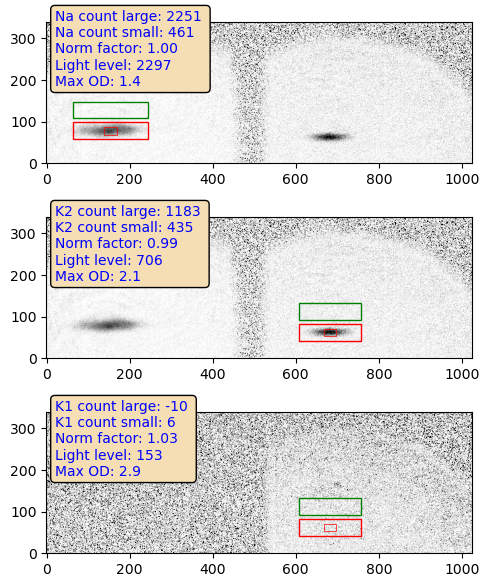

In [719]:
# sample h5_path:
h5_path = "/Volumes/Fermi1/Experiments/fermi1_apparatus/BENCHMARK_thermal_dimer_trimer/2023/10/20/0068/2023-10-20_0068_BENCHMARK_thermal_dimer_trimer_01.h5"
analysis_settings_path = os.path.dirname(h5_path) + '/getTripleImagingZcamAnalysis_2021_last_settings.pkl'
# get image from h5_path:
image_paths = get_image_paths(h5_path)
# get frames from one .spe image:
frames = get_frames_from_absorption_image_path(image_paths[1])
# get analysis settings from analysis settings path:
analysis_settings = get_analysis_settings(analysis_settings_path)
# get analysis results
result_dict = zcam_triple_image_analysis(filepath_Na=image_paths[1], filepath_K2=image_paths[1], filepath_K1=image_paths[2], autocenter=True, center_search_mode='gaussian')

In [472]:
with open('/Users/huanbui/Desktop/Repositories/huanium/MIT_PhD/Fermi1/data/2023/Oct/dimerTrimer101G_2Vmxr_100msBlackman_ODTTrunc_1_NaF2/dataframe_20231020T180708_BENCHMARK_thermal_dimer_trimer.pkl', 'rb') as f:
    df = pickle.load(f)
print(df['filepath'][73])
print(df['zcam_triple_analysis']['Na_NcntLarge'][73])
print(df['zcam_triple_analysis']['K2_NcntLarge'][73])
print(df['zcam_triple_analysis']['K1_NcntLarge'][73])

Z:\Experiments\fermi1_apparatus\BENCHMARK_thermal_dimer_trimer\2023\10\20\0068\2023-10-20_0068_BENCHMARK_thermal_dimer_trimer_00.h5
2350.1359439863627
706.6207657639025
19.655287390771882
